In [1]:
import pandas as pd 
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pickle


In [2]:
class RegressionNet(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
df_Desai_15loci_complete=pd.read_csv('../data/df_Desai_15loci_complete.csv',index_col=0)


In [4]:
df_Desai_15loci_complete['mutant_sequence'][0]

'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'

In [5]:
df_Desai_15loci_complete = df_Desai_15loci_complete[df_Desai_15loci_complete['log10Kd_ACE2'] != 5]


In [6]:
EMBED='mean_representation'
def list_series_to_tensor(df, col_name):
    return torch.tensor(df[col_name].tolist(), dtype=torch.float32)
df_Desai_15loci_complete[EMBED]=df_Desai_15loci_complete[EMBED].apply(lambda x: [float(i) for i in x.replace('[','').replace(']','').split(', ')])


In [7]:

features = ['log10Kd_ACE2', 'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']

seed = 10
# sample_size = int(len(df_Desai_15loci_complete) * 0.8)
df_train = df_Desai_15loci_complete.sample(n=20000, random_state=seed)
df_val = df_Desai_15loci_complete.drop(df_train.index)
# Convert dataframes to tensors using the custom function
train_X = list_series_to_tensor(df_train, EMBED)
train_y = torch.stack([
    list_series_to_tensor(df_train, 'log10Kd_ACE2'),
    list_series_to_tensor(df_train, 'log10Kd_CB6'),
    list_series_to_tensor(df_train, 'log10Kd_CoV555'),
    list_series_to_tensor(df_train, 'log10Kd_REGN10987'),
    list_series_to_tensor(df_train, 'log10Kd_S309')
], dim=-1)

val_X = list_series_to_tensor(df_val, EMBED)
val_y = torch.stack([
    list_series_to_tensor(df_val, 'log10Kd_ACE2'),
    list_series_to_tensor(df_val, 'log10Kd_CB6'),
    list_series_to_tensor(df_val, 'log10Kd_CoV555'),
    list_series_to_tensor(df_val, 'log10Kd_REGN10987'),
    list_series_to_tensor(df_val, 'log10Kd_S309')
], dim=-1)
# DataLoader creation
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(val_X, val_y), batch_size=32)



In [8]:
import torch.nn as nn
import torch.optim as optim


# Hyperparameters and Model instantiation
input_dim = 1280 
output_dim = len(features)
model = RegressionNet(input_dim, 64, 32, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 40
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
model.eval()
with torch.no_grad():
    total_loss = 0
    for batch_X, batch_y in val_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        total_loss += loss.item()

    avg_val_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")


Epoch [1/40], Loss: 2.4616
Epoch [2/40], Loss: 2.0489
Epoch [3/40], Loss: 1.8404
Epoch [4/40], Loss: 1.0996
Epoch [5/40], Loss: 0.6629
Epoch [6/40], Loss: 0.6317
Epoch [7/40], Loss: 0.7470
Epoch [8/40], Loss: 0.5628
Epoch [9/40], Loss: 0.5989
Epoch [10/40], Loss: 0.5553
Epoch [11/40], Loss: 0.7808
Epoch [12/40], Loss: 0.6551
Epoch [13/40], Loss: 0.5182
Epoch [14/40], Loss: 0.5929
Epoch [15/40], Loss: 0.5589
Epoch [16/40], Loss: 0.3828
Epoch [17/40], Loss: 0.4007
Epoch [18/40], Loss: 0.5386
Epoch [19/40], Loss: 0.6332
Epoch [20/40], Loss: 0.6140
Epoch [21/40], Loss: 0.3924
Epoch [22/40], Loss: 0.5056
Epoch [23/40], Loss: 0.4394
Epoch [24/40], Loss: 0.4522
Epoch [25/40], Loss: 0.5660
Epoch [26/40], Loss: 0.3896
Epoch [27/40], Loss: 0.2865
Epoch [28/40], Loss: 0.3567
Epoch [29/40], Loss: 0.6075
Epoch [30/40], Loss: 0.3853
Epoch [31/40], Loss: 0.4287
Epoch [32/40], Loss: 0.4921
Epoch [33/40], Loss: 0.3044
Epoch [34/40], Loss: 0.4206
Epoch [35/40], Loss: 0.5279
Epoch [36/40], Loss: 0.3872
E

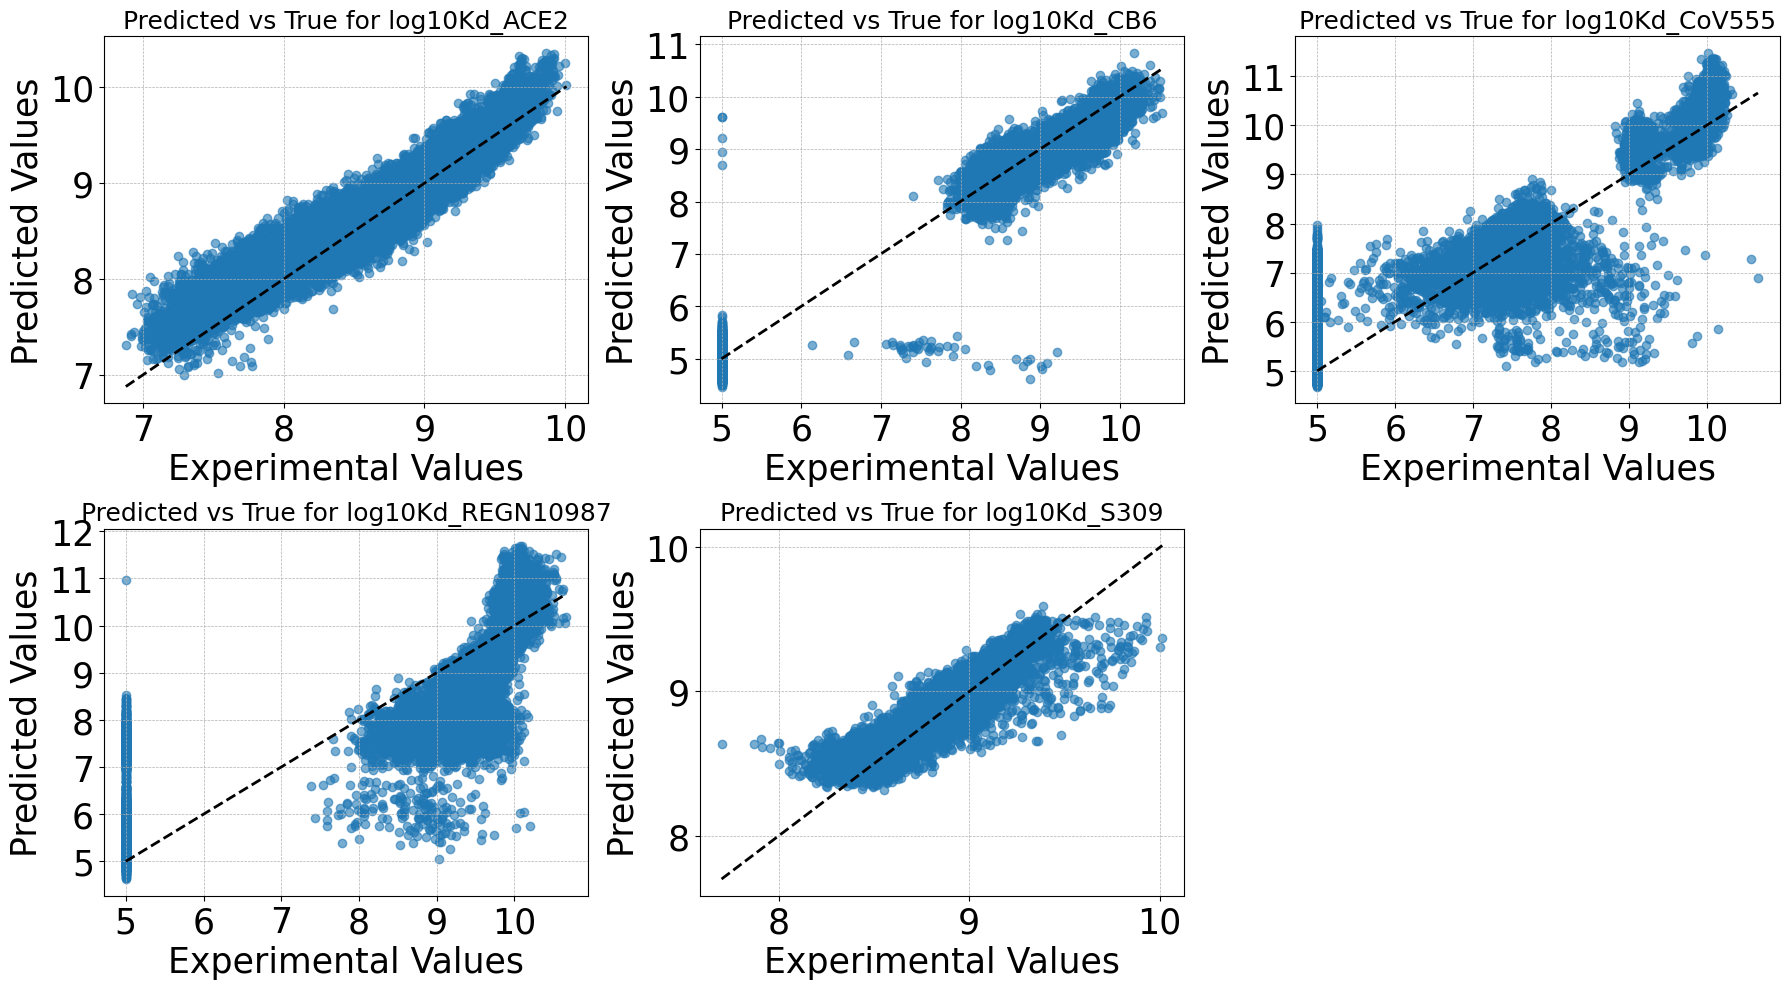

In [9]:
from matplotlib.ticker import MaxNLocator
model.eval()
with torch.no_grad():
    val_predictions = model(val_X)
val_predictions_np = val_predictions.numpy()

true_values = val_y.numpy()

#Plot predicted vs. true values for each Kd
feature_names = ["log10Kd_ACE2", "log10Kd_CB6", "log10Kd_CoV555", "log10Kd_REGN10987", "log10Kd_S309"]

plt.figure(figsize=(18, 10))

for i, feature in enumerate(feature_names):
    plt.subplot(2, 3, i+1)
    plt.scatter(true_values[:, i], val_predictions_np[:, i], alpha=0.6)
    plt.plot([min(true_values[:, i]), max(true_values[:, i])], [min(true_values[:, i]), max(true_values[:, i])],  color='black', linestyle='--', linewidth=2, label='Perfect fit')
    plt.xlabel('Experimental Values',fontsize=25)
    plt.ylabel('Predicted Values',fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.title(f"Predicted vs True for {feature}",fontsize=18)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax = plt.gca()  # Get current axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.savefig('../paper/BP_SI_ML_KD.png', dpi=300)
plt.show()


In [10]:
import numpy as np
from sklearn.metrics import r2_score
# Calculate R^2 for each feature
r2_scores = {}
feature_names = ["log10Kd_ACE2", "log10Kd_CB6", "log10Kd_CoV555", "log10Kd_REGN10987", "log10Kd_S309"]

for i, feature in enumerate(feature_names):
    r2_scores[feature] = r2_score(true_values[:, i], val_predictions_np[:, i])

r2_scores

{'log10Kd_ACE2': 0.878697931316466,
 'log10Kd_CB6': 0.977209625610477,
 'log10Kd_CoV555': 0.8350343795179296,
 'log10Kd_REGN10987': 0.7537208453120772,
 'log10Kd_S309': 0.8105086830109417}

In [11]:
def logistic_model_log(x):
    a = 2.2729143960584444
    C = 6.379113074730051e-07
    K_1 = 9.186716428908625e-08
    K_2 = 6.797174616389154e-08
    K_3 = 6.70297161650805e-08
    K_4 = 4.3634871535208524e-07
    T = 1.6
    return a * (1 + C * np.exp(np.log(10) * x[0] / T)) / (C * np.exp(np.log(10) * x[0] / T) + K_1 * np.exp(np.log(10) * x[1] / T) + K_2 * np.exp(np.log(10) * x[2] / T) + K_3 * np.exp(np.log(10) * x[3] / T) + K_4 * np.exp(np.log(10) * x[4] / T)+ 1)
def logistic_model_wo_log(x):
    a =  1.5820504256318644
    C =  5.561598293846435e-07
    K_1 = 5.8192980137302794e-08
    K_2 = 4.662506187958737e-08
    K_3 =  7.280867393144767e-08
    K_4 = 4.768151818231864e-07
    T=1.6
    return a * (1 + C * np.exp(np.log(10) * x[0] / T)) / (C * np.exp(np.log(10) * x[0] / T) + K_1 * np.exp(np.log(10) * x[1] / T) + K_2 * np.exp(np.log(10) * x[2] / T) + K_3 * np.exp(np.log(10) * x[3] / T) + K_4 * np.exp(np.log(10) * x[4] / T)+ 1)


In [12]:
df_Desai_15loci_existed = df_Desai_15loci_complete[df_Desai_15loci_complete['average_date']!='5']

## load unique embedding

In [13]:
# Load the DataFrame
with open('../data/unique_mutant_sequence_emb_esm1v_650m.pkl', 'rb') as file:
    unique_embedding= pickle.load(file)
unique_embedding = pd.DataFrame(unique_embedding)
rbd_withtime = pd.read_csv('/Users/wangdz/Shakhnovich/RBD_fitness/time_labels/data/rbd_df.csv')


In [14]:
import pandas as pd


# Rename 'seq' column to 'mutant_sequence'
rbd_withtime.rename(columns={'seq': 'mutant_sequence'}, inplace=True)

# Convert the 'date' column to datetime
rbd_withtime['date'] = pd.to_datetime(rbd_withtime['date'], format='%Y-%m-%d', errors='coerce')

earliest_dates_df = rbd_withtime.groupby('mutant_sequence').agg(
    earliest_date=('date', 'min'),          
    q05=('date', lambda x: x.quantile(0.05).normalize() if pd.notnull(x.quantile(0.05)) else pd.NaT)
).reset_index()



In [15]:
#rename sequence to mutant_sequence
unique_embedding = unique_embedding.rename(columns={'sequence':'mutant_sequence'})

In [16]:
unique_embedding = unique_embedding.merge(earliest_dates_df, on='mutant_sequence', how='left')

In [17]:

import csv
# Read TSV file
with open("/Users/wangdz/Shakhnovich/RBD_fitness/mutations.tsv", "r") as file:
    reader = csv.reader(file, delimiter="\t")
    headers = next(reader)  # Skip the header row
    mutations = [dict(zip(headers, row)) for row in reader]

# Create a pandas DataFrame from the mutations list
mutations_df = pd.DataFrame(mutations)

# Extract positions from the mutation column and convert to integers
mutations_df["position"] = mutations_df["mutation"].str.extract(r"(\d+)").astype(int)

s_mutations_df = mutations_df[mutations_df["mutation"].str.startswith("S:")].copy()





In [18]:
wt = 'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'

unique_embedding['diff'] = unique_embedding['mutant_sequence'].apply(
    lambda x: [(wt[i], i+331, x[i]) for i in range(len(x)) if x[i] != wt[i]])

In [19]:
# Creating the mapping dictionary from found_mutations
# Make sure Δ log R values are floats
mutation_to_delta_log_R = dict(zip(s_mutations_df['mutation'], s_mutations_df['Δ log R'].astype(float)))

# Function to convert mutation tuple to string format with "S:" prefix
def mutation_tuple_to_string(mutation_tuple):
    return f"S:{mutation_tuple[0]}{mutation_tuple[1]}{mutation_tuple[2]}"

# Function to sum Δ log R values for mutations in a row
# If a mutation does not exist in the mapping, return None to indicate the row should be skipped
def sum_delta_log_R(mutations):
    delta_log_R_sum = 0
    for mut in mutations:
        mutation_string = mutation_tuple_to_string(mut)
        if mutation_string in mutation_to_delta_log_R:
            delta_log_R_sum += mutation_to_delta_log_R[mutation_string]
        else:
            # If the mutation is not found, return None
            # delta_log_R_sum += 0.03 
            return None
    return np.exp(delta_log_R_sum)

unique_embedding['science_fitness'] = unique_embedding['diff'].apply(sum_delta_log_R)

# Filter the DataFrame to exclude rows where 'science_fitness' is None
filtered_unique_embedding = unique_embedding.dropna(subset=['science_fitness'])

# Now 'filtered_unique_embedding' is the smaller DataFrame with all variants consisting of mutations that appeared in s_mutations_df


In [20]:
unique_X = list_series_to_tensor(filtered_unique_embedding, EMBED)


In [21]:
unique_X = list_series_to_tensor(filtered_unique_embedding, EMBED)
model.eval()
with torch.no_grad():
    unique_predictions = model(unique_X)

In [22]:
len(unique_X)

5460

In [23]:
unique_predictions_np = unique_predictions.numpy()
filtered_unique_embedding.loc[:, ['log10Kd_ACE2', 'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']] = unique_predictions_np
filtered_unique_embedding_with_T478K = filtered_unique_embedding[filtered_unique_embedding['mutant_sequence'].apply(lambda x: x[478-331] == 'K')]
filtered_unique_embedding_without_T478K = filtered_unique_embedding[filtered_unique_embedding['mutant_sequence'].apply(lambda x: x[478-331] == 'T')]

In [24]:
filtered_unique_embedding_with_T478K['BP_fitness'] = np.apply_along_axis(logistic_model_log, 1, filtered_unique_embedding_with_T478K[['log10Kd_ACE2', 'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']].to_numpy())
filtered_unique_embedding_without_T478K['BP_fitness'] = np.apply_along_axis(logistic_model_wo_log, 1, filtered_unique_embedding_without_T478K[['log10Kd_ACE2', 'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']].to_numpy())
df = pd.concat([filtered_unique_embedding_with_T478K, filtered_unique_embedding_without_T478K])


/var/folders/4s/fnn1b0255fb95977rmg73gx40000gn/T/ipykernel_23349/903528493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_unique_embedding_with_T478K['BP_fitness'] = np.apply_along_axis(logistic_model_log, 1, filtered_unique_embedding_with_T478K[['log10Kd_ACE2', 'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']].to_numpy())
/var/folders/4s/fnn1b0255fb95977rmg73gx40000gn/T/ipykernel_23349/903528493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_unique_embedding

In [25]:
mask = ~df['mutant_sequence'].isin(df_Desai_15loci_complete['mutant_sequence'])

# Apply the mask to filter out the rows
result_df = df[mask].copy()



In [26]:
def get_variant_sequence(wt_sequence, mutations):
    wt_sequence_list = list(wt_sequence)
    
    # Apply each mutation to the wild type sequence
    for mutation in mutations:
        # Parse the mutation string (e.g., 'K417N')
        original_aa, position, mutated_aa = mutation[0], int(mutation[1:-1]), mutation[-1]
        
        # Check if the original amino acid matches the wild type sequence at the specified position
        if wt_sequence_list[position - 331] != original_aa:
            raise ValueError(f"Expected {original_aa} at position {position}, but found {wt_sequence_list[position - 331]} in the wild type sequence.")
        # Perform the mutation
        wt_sequence_list[position - 331] = mutated_aa
    
    # Convert the list back to a string to get the final variant sequence
    variant_sequence = ''.join(wt_sequence_list)
    return variant_sequence


delta_sequence = get_variant_sequence(wt, ['K417N', 'T478K', 'E484K', 'L452R'])
beta_sequence = get_variant_sequence(wt,['K417N', 'E484K', 'N501Y'])
gamma_sequence = get_variant_sequence(wt,['K417T', 'E484K', 'N501Y'])
omicronBA2_sequence = get_variant_sequence(wt,['G339D','S371F','S373P','S375F','T376A','D405N','R408S','K417N','N440K','S477N','T478K','E484A','Q493R','Q498R','N501Y','Y505H'])
omicronBA3_sequence = get_variant_sequence(wt,['G339D','S371F','S373P','S375F','D405N','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','Q498R','N501Y','Y505H'])
omicronBA4_sequence = get_variant_sequence(wt,['G339D','S371F','S373P','S375F','T376A','D405N','R408S','K417N','N440K','L452R','S477N','T478K','E484A','F486V','Q498R','N501Y','Y505H'])
XBB_sequence = get_variant_sequence(wt,['G339H', 'R346T', 'L368I', 'S371F', 'S373P', 'S375F', 'T376A', 'D405N','R408S', 'K417N', 'N440K', 'V445P', 'G446S', 'N460K', 'S477N', 'T478K', 'E484A', 'F486S', 'F490S', 'Q498R','N501Y','Y505H'] )
variant_sequences = [delta_sequence, omicronBA2_sequence, omicronBA3_sequence, omicronBA4_sequence]


In [27]:
result_df[result_df['mutant_sequence']==gamma_sequence]

,label,mutant_sequence,cls_representation,mean_representation,max_representation,mean_delta_representation,max_delta_representation,earliest_date,q05,diff,science_fitness,log10Kd_ACE2,log10Kd_CB6,log10Kd_CoV555,log10Kd_REGN10987,log10Kd_S309,BP_fitness
27,1521,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,"[0.5710974335670471, -0.09217609465122223, -0....","[-0.14398632943630219, -0.08556883037090302, 0...","[0.25134891271591187, 0.26045531034469604, 0.4...","[-0.16072861850261688, -0.013654281385242939, ...","[0.0, 0.11773999780416489, 0.2704099416732788,...",2020-04-07,2021-03-14,"[(K, 417, T), (E, 484, K), (N, 501, Y)]",1.162087,9.340605,8.39919,8.135934,10.040752,9.451222,1.138825


In [28]:
result_df['highlight'] = result_df['mutant_sequence'].apply(lambda x: 0)

In [29]:
result_df.loc[result_df['mutant_sequence'] == delta_sequence, 'highlight'] = 1
result_df.loc[result_df['mutant_sequence'] == beta_sequence, 'highlight'] = 1
result_df.loc[result_df['mutant_sequence'] == gamma_sequence, 'highlight'] = 1

result_df.loc[result_df['label']=='8782574', 'highlight']= 1 #BA2  
result_df.loc[result_df['mutant_sequence'] == omicronBA3_sequence, 'highlight'] = 1
result_df.loc[result_df['label']=='8272657', 'highlight']= 1 #BA4

In [30]:
columns_to_check = [ 'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']
result_df = result_df.loc[
    (result_df[columns_to_check] < 11).all(axis=1)
]

In [31]:
time_filtered_unique_embedding = result_df[result_df['q05'] >= '2020-01-01']

In [32]:
# delta sequence: https://www.nature.com/articles/s41392-021-00863-2
#beta https://bpsbioscience.com/spike-rbd-b-1-351-beta-variant-avi-his-tag-sars-cov-2-recombinant-100978
# Omicron BA2 BA3: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8845508/
# Omicron BA4 BA5: https://www.nature.com/articles/s41591-022-01911-2
#XBB https://www.sinobiological.com/recombinant-proteins/sars-cov-2-cov-spike-40592-v08h144

In [33]:
df_Desai_15loci_complete.columns

Index(['mutant_sequence', 'log10Kd_ACE2', 'log10Kd_CB6', 'log10Kd_CoV555',
       'log10Kd_REGN10987', 'log10Kd_S309', 'count', 'real_f', 'pred_f',
       'average_date', 'mean_representation'],
      dtype='object')

In [34]:
result_df.columns
#calculate correlation between log10Kd_ACE2 and log10Kd_CB6
correlation, p_value = spearmanr(result_df['log10Kd_ACE2'], result_df['log10Kd_S309'])
correlation

-0.2842237817724751

In [35]:
correlation, p_value = spearmanr(df_Desai_15loci_complete['log10Kd_ACE2'], df_Desai_15loci_complete['log10Kd_S309'])
correlation

-0.05226908014047846

In [36]:
plot_variants = pd.read_csv('../data/plot_strain.csv')

plot_variants

,birthday,strain,filtered_mutations,science_fitness,BP_fitness
0,10/16/20,B.1.1.101,"S:L452R,S:T478K,S:E484A",1.510628,1.346588
1,none,XAD,"S:G339D,S:S371F,S:S373P,S:S375F,S:T376A,S:D405...",2.375880,1.957952
2,none,XAB,"S:G339D,S:S371F,S:S373P,S:S375F,S:T376A,S:D405...",2.500334,2.028034
3,4/20/22,BA.2.13,"S:G339D,S:S371F,S:S373P,S:S375F,S:D405N,S:K417...",2.263141,2.091186
4,6/24/22,BA.5.1,"S:G339D,S:S371F,S:S373P,S:S375F,S:T376A,S:D405...",2.683091,2.046597
5,none,XAE,"S:G339D,S:S371F,S:S373P,S:S375F,S:T376A,S:R408...",2.284434,1.951467
6,1/10/20,B.1.36,S:A520S,0.999814,1.017834
7,1/10/20,B.1.489,S:P479S,1.000107,1.086622
8,5/12/20,AV.1,"S:Y449H,S:N501Y",1.040652,0.985674
9,8/1/20,B.1.466,"S:E484K,S:S494P",1.101189,0.953990


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


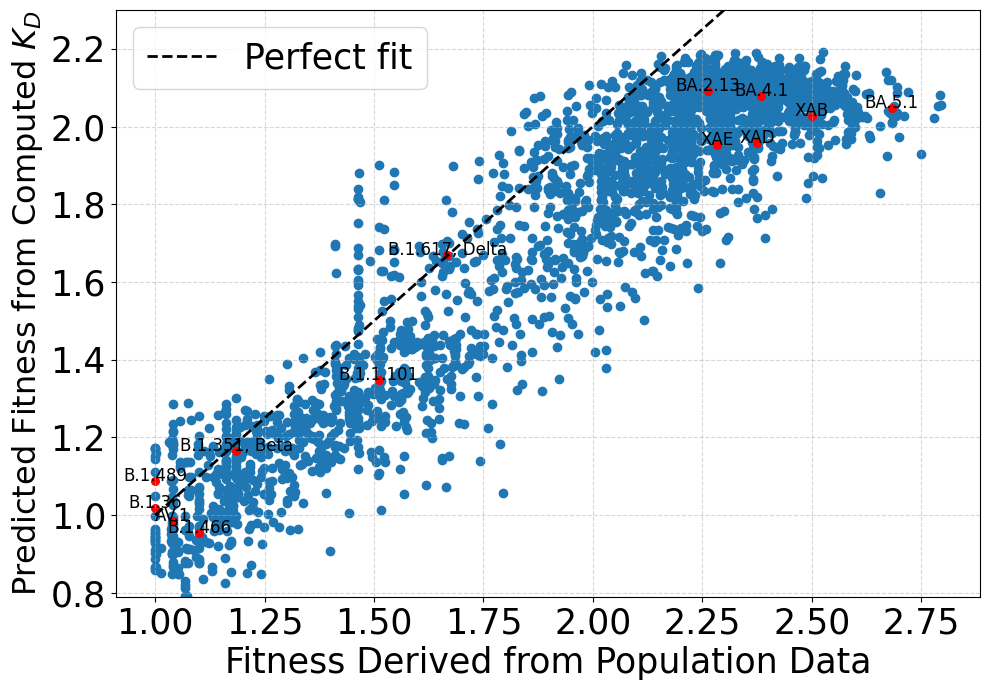

Spearman correlation: 0.86
p-value: 0


In [37]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

plt.figure(figsize=(10, 7))

# Scatter plot for not_highlighted (default color)
plt.scatter(time_filtered_unique_embedding['science_fitness'], time_filtered_unique_embedding['BP_fitness'])

# Scatter plot for highlighted (red color)
plt.scatter(plot_variants['science_fitness'], plot_variants['BP_fitness'], color='red',s=30)
for i, row in plot_variants.iterrows():
    plt.text(row['science_fitness'], row['BP_fitness'], row['strain'], fontsize=12, ha='center')

# Plot y = x line
plt.plot(np.unique(time_filtered_unique_embedding['science_fitness'],), np.unique(time_filtered_unique_embedding['science_fitness'],), color='black', linestyle='--', linewidth=2, label='Perfect fit')


# Adding a legend
plt.xlabel('Fitness Derived from Population Data', fontsize=25)
plt.ylabel('Predicted Fitness from Computed $K_D$', fontsize=23)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.ylim(0.79,2.3)
plt.tight_layout()
plt.savefig('../paper/predict_MLBP.png', dpi=300)

plt.show()

# Calculating Spearman correlation
correlation, p_value = spearmanr(time_filtered_unique_embedding['science_fitness'], time_filtered_unique_embedding['BP_fitness'])
print(f'Spearman correlation: {correlation:.2f}')
print(f'p-value: {p_value:.2g}')


In [38]:
# Drop rows where 'earliest_date' is NaT
result_df_filtered = result_df[(result_df['q05'] >= '2020-01-01') & (result_df['q05'] <= '2023-01-01')]
result_df_sorted = result_df_filtered.sort_values('q05')
result_df_cleaned = result_df_sorted.dropna(subset=['q05'])
# Set the 'earliest_date' column as the index
time_indexed_result_df = result_df_cleaned.set_index('q05')


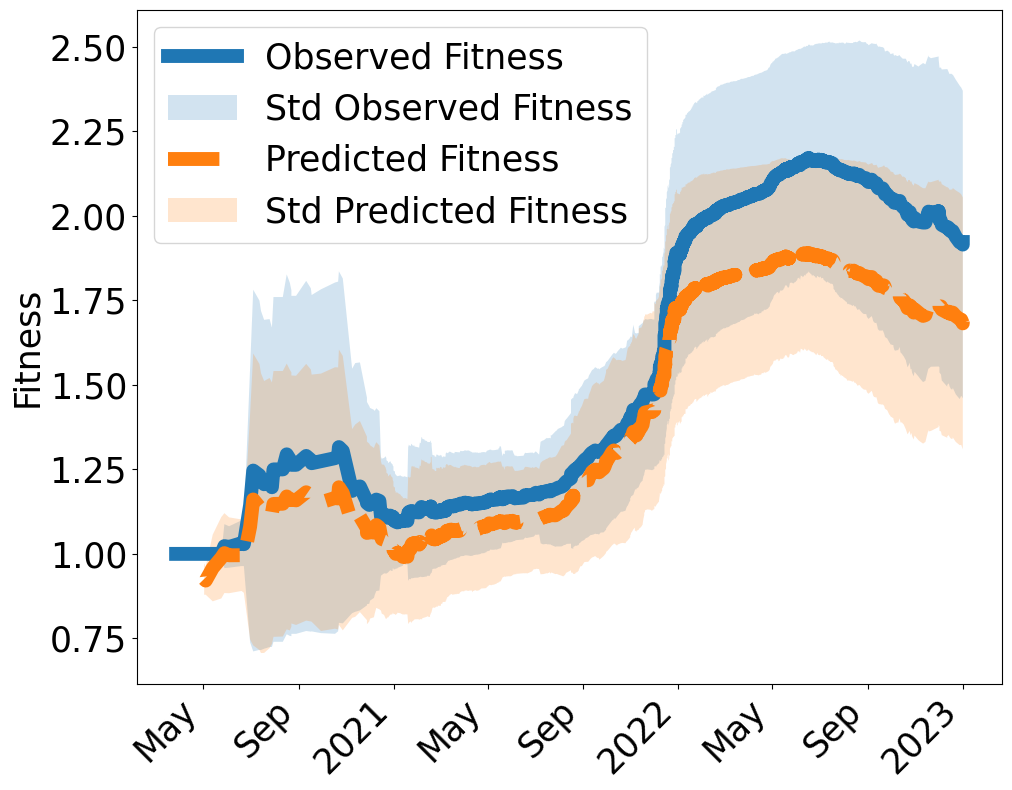

In [39]:

time_indexed_result_df['rolled_real_f']=time_indexed_result_df['science_fitness'].rolling('120D').mean()
time_indexed_result_df['rolled_real_f_std']=time_indexed_result_df['science_fitness'].rolling('120D').std()
time_indexed_result_df['rolled_pred_f']=time_indexed_result_df['BP_fitness'].rolling('120D').mean()
time_indexed_result_df['rolled_pred_f_std']=time_indexed_result_df['BP_fitness'].rolling('120D').std()

import matplotlib.dates as mdates

plt.figure(figsize=(10, 8))

# Increase the linewidth to make the lines more visible
time_indexed_result_df['rolled_real_f'].plot(label='Observed Fitness', linewidth=10.0)
plt.fill_between(time_indexed_result_df.index, 
                 time_indexed_result_df['rolled_real_f']-time_indexed_result_df['rolled_real_f_std'], 
                 time_indexed_result_df['rolled_real_f']+time_indexed_result_df['rolled_real_f_std'], 
                 alpha=0.2, label='Std Observed Fitness')

# Plot prediction starting from the 15th point
time_indexed_result_df['rolled_pred_f'].iloc[3:].plot(label='Predicted Fitness', linewidth=10.0, linestyle='--')
plt.fill_between(time_indexed_result_df.index[3:], 
                 time_indexed_result_df['rolled_pred_f'].iloc[3:]-time_indexed_result_df['rolled_pred_f_std'].iloc[3:], 
                 time_indexed_result_df['rolled_pred_f'].iloc[3:]+time_indexed_result_df['rolled_pred_f_std'].iloc[3:], 
                 alpha=0.2, label='Std Predicted Fitness')

#plt.title('Prediction of Relative Fitness of Variants after ' + DATE, fontsize=18)
plt.xlabel('', fontsize=25)
plt.ylabel('Fitness', fontsize=25)
plt.legend(loc='upper left', fontsize=25)

# Set the tick parameters
plt.tick_params(axis='x', rotation=45, labelsize=25)
plt.tick_params(axis='y', labelsize=25)

# Use automatic date formatter
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.savefig('../paper/predicting_trajectory.png', format='png', dpi=300)
plt.show()



In [40]:
highlight_variants = pd.read_csv('../data/highlight_strain.csv')


In [41]:
# Drop rows where 'earliest_date' is NaT
result_df_filtered = result_df[(result_df['q05'] >= '2019-01-01') & (result_df['q05'] <= '2023-09-01')]
result_df_sorted = result_df.sort_values('q05')
result_df_cleaned = result_df_sorted.dropna(subset=['q05'])

# Set the 'earliest_date' column as the index
time_indexed_result_df = result_df_cleaned.set_index('q05')

In [42]:
strains_df = pd.read_csv('../data/strains.tsv', sep='\t')
import re

def filter_spike_mutations(mutations):
    if not isinstance(mutations, str):
        return ''  # Return an empty string if it's not a string (e.g., NaN or float)

    # Split the mutations string into individual mutations
    mutation_list = mutations.split(',')

    # Filter for spike mutations in the specified range
    filtered_mutations = []
    for m in mutation_list:
        if m.startswith('S:'):
            # Use regular expression to extract the number from the mutation
            match = re.search(r'\d+', m)
            if match:
                mutation_num = int(match.group())
                if 331 <= mutation_num <= 520:
                    filtered_mutations.append(m)
    filtered_mutations.sort(key=lambda x: int(re.search(r'\d+', x).group()))

    # Join the filtered mutations back into a string
    return ','.join(filtered_mutations)

# Apply the function to the 'mutations' column
strains_df['filtered_mutations'] = strains_df['mutations'].apply(filter_spike_mutations)
def convert_diff_format_to_string(diff_list):
    # Convert each tuple in the list to the string format
    return ','.join([f"S:{original}{pos}{mutant}" for original, pos, mutant in diff_list])

# Assuming result_df is your DataFrame with the 'diff' column in diff_format
result_df['mutations_string'] = result_df['diff'].apply(convert_diff_format_to_string)

# Now, 'mutations_string' column in result_df is in the same format as 'filtered_mutations' in strains_df
merged_df = pd.merge(result_df, strains_df, left_on='mutations_string', right_on='filtered_mutations', how='inner')



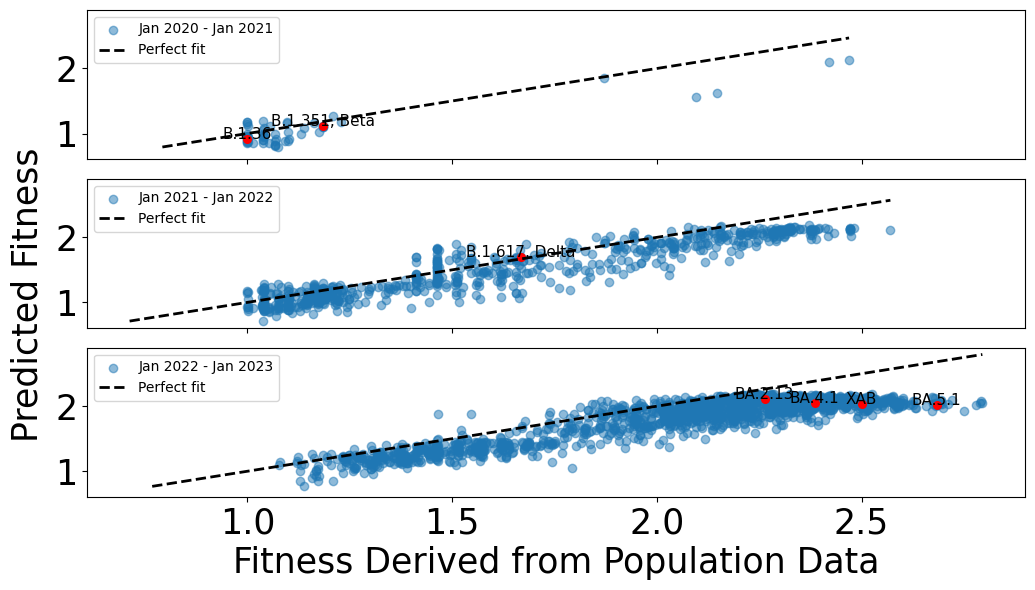

Spearman correlation for panel 1: 0.42
Spearman correlation for panel 2: 0.92
Spearman correlation for panel 3: 0.77


In [43]:

rolling_windows = pd.date_range(start='2020-01-01', end='2023-01-01', freq='366D')
spearman_correlations=[]

# Create subplots for each rolling window scatter plot
n_windows = len(rolling_windows)
fig, axes = plt.subplots(n_windows, 1, figsize=(10, 2 * n_windows), sharex=True, sharey=True)
all_label_df = pd.merge(
    left=result_df,
    right=highlight_variants,
    left_on='mutations_string',
    right_on='filtered_mutations',
    how='inner'
)

# Loop through each rolling window and plot scatter plot on a separate subplot
for i, start_date in enumerate(rolling_windows):
    end_date = start_date + pd.Timedelta(days=366)
    mask = (time_indexed_result_df.index >= start_date) & (time_indexed_result_df.index < end_date)
    window_df = time_indexed_result_df.loc[mask]
    mask_label = (all_label_df['q05'] >= start_date) & (all_label_df['q05'] < end_date)
    label_df = all_label_df.loc[mask_label]
    ax = axes[i] if n_windows > 1 else axes

    # Scatter plot for the current rolling window
    ax.scatter(window_df['science_fitness'], window_df['BP_fitness'], alpha=0.5, label=f'{start_date.strftime("%b %Y")} - {end_date.strftime("%b %Y")}')
    
    # Plot y=x line
    max_fitness = max(window_df['science_fitness'].max(), window_df['BP_fitness'].max())
    min_fitness = min(window_df['science_fitness'].min(), window_df['BP_fitness'].min())
    ax.plot([min_fitness, max_fitness], [min_fitness, max_fitness], color='black', linestyle='--', linewidth=2, label='Perfect fit')

    # Highlight specific points for 'plot_variants' on the current rolling window
    ax.scatter(label_df['science_fitness_x'], label_df['BP_fitness_x'], color='red', s=30)
    
    # Annotate points with the 'strain' name
    for _, row in label_df.iterrows():
        ax.text(row['science_fitness_x'], row['BP_fitness_x'], row['strain'], fontsize=11, ha='center')
    spearman_corr, _ = spearmanr(window_df['science_fitness'], window_df['BP_fitness'])
    spearman_correlations.append(spearman_corr)

    ax.legend()
    # ax.set_ylabel('Predicted Fitness', fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    

# Set the xlabel for only the last subplot
axes[-1].set_xlabel('Fitness Derived from Population Data', fontsize=25)
fig.text(-0.03, 0.5, 'Predicted Fitness', va='center', rotation='vertical', fontsize=25)
plt.tight_layout()
plt.savefig('../paper/bp_vs_science_fitness_over_time.png', dpi=300, bbox_inches='tight')
plt.show()
for i, corr in enumerate(spearman_correlations):
    print(f"Spearman correlation for panel {i+1}: {corr:.2f}")